In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)

#Function to generate a 3-panel plot for input arrays
def plot2panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)


In [2]:
#! /usr/bin/env python
"""
Compute emergence velocities for input DEMs, surface velocities and glacier polygons
"""

import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

#Avoid printing out divide by 0 errors
np.seterr(all='ignore')

"""
Class to store relevant feature attributes and derived values
Safe for multiprocessing
"""
class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()

#RGI uses 50 m bins
def hist_plot(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0)):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
#         emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
#             emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
#             if emvel_bin_samp.size > min_bin_samp_count:
#                 emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
#                 emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_bins_DRR_v2.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

    #Create plots of elevation bins
    #print("Generating aed plot")
    #f,axa = plt.subplots(1,2, figsize=(6, 6))
    nsubplots = 0
    if gf.dhdt is not None:
        nsubplots += 1
    if gf.debris_thick is not None:
        nsubplots += 1
    if gf.vm is not None:
        nsubplots += 1
    if gf.H is not None:
        nsubplots += 1
    print(nsubplots)
    f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
    f.suptitle(gf.feat_fn)
    fs = 9
    nplot = -1
    if gf.dhdt is not None:
        nplot += 1
        axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
        axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
        if gf.z2 is not None:
            axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
            axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
        axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[0])

        nplot += 1
        axa[0,nplot].axvline(0, lw=1.0, c='k')
        """
        #Plot flux divergence values for each bin
        if gf.vm is not None and gf.H is not None:
            divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
            axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
        """
        axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
        axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
        #axa[nplot].set_xlabel('dh/dt (m/yr)')
        axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[1])
        #Hide y-axis labels
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].set_xlim(*dz_clim)

    if gf.debris_thick is not None:
        nplot += 1
        axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
    if gf.debris_class is not None:
        axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
        axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
    if gf.debris_thick is not None or gf.debris_class is not None:
        axa[0,nplot].set_xlim(0, 100)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[2])
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

    if gf.H is not None:
        nplot += 1
        axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
        axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='lower right')
        # pltlib.minorticks_on(axa[3])
        #axa[nplot].set_xlim(0, 400)
        axa[0,nplot].yaxis.tick_left()
        axa[0,nplot].yaxis.set_ticks_position('both')
        axa[0,nplot].yaxis.set_label_position("right")
    
    if gf.vm is not None:
        nplot += 1
#         ax4 = axa[0,nplot].twinx()
        axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
        axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
        #ax4.set_xlim(0, 50)
        axa[0,nplot].xaxis.tick_bottom()
        axa[0,nplot].xaxis.set_label_position("bottom")
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
        nplot += 1
#         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         gf.divQ
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

    plt.tight_layout()
    #Make room for suptitle
    plt.subplots_adjust(top=0.95, wspace=0.1)
    #print("Saving aed plot")
    fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
    #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)
    return z_bin_edges

In [3]:
#INPUT
topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
#Output directory
outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
outdir_fig = outdir + '/figures/'
outdir_csv = outdir + '/csv'

#RGI inventory
glac_str = '15.03473'
# glac_shp_fn = topdir + '../RGI/rgi60/01_rgi60_Alaska/01_rgi60_Alaska.shp'
glac_shp_fn = topdir + '../RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'
glacfeat_fn = outdir + 'glacfeat_list.p'
#DEM
z1_dir = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/surface_DEMs_RGI60-15/'
z1_fn = z1_dir +  'surface_DEM_RGI60-' + glac_str + '.tif'
# Ice thickness
huss_dir = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/'
huss_fn = 'RGI60-' + glac_str + '_thickness.tif'
# huss_dir = '/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/rounce_model/kennicott_data/'
# huss_fn = 'thick_kennicott_HH2012.tif'


#Output projection
proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
ds = gdal.Open(proj_fn)
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
aea_srs = srs

#Surface velocity
v_dir = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/ITS_Live'
vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

#Filter glacier poly - let's stick with big glaciers for now
min_glac_area = 2 #km^2
#Only write out for larger glaciers
min_glac_area_writeout = 2.
#Minimum percentage of glacier poly covered by valid dz
min_valid_area_perc = 0.6       # DSHEAN WAS 0.85
#Process thickness, velocity, etc
extra_layers = True
#Write out DEMs and dz map
writeout = True
#Generate figures
mb_plot = True
# #Run in parallel, set to False for serial loop
# parallel = False
#Verbose for debugging
verbose = True
# #Number of parallel processes
# #Use all virtual cores
# #nproc = iolib.cpu_count(logical=True) - 1
# #Use all physical cores
# # nproc = iolib.cpu_count(logical=False) - 1
# nproc = 1
#Shortcut to use existing glacfeat_list.p if found
use_existing_glacfeat = True

#Pad by this distance (meters) around glacier polygon for uncertainty estimates over surrounding surfaces
buff_dist = 1000

#Bin width
bin_width = 5

#Surface to column average velocity scaling
v_col_f = 0.8

#This is recommendation by Huss et al (2013)
rho_is = 0.85
rho_sigma = 0.06


if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(outdir_fig):
    os.makedirs(outdir_fig)
if not os.path.exists(outdir_csv):
    os.makedirs(outdir_csv)

# ts = datetime.now().strftime('%Y%m%d_%H%M')

In [4]:
# Process RGI shapefile
if 'rgi' in glac_shp_fn or 'Kennicott' in glac_shp_fn:
    #Use RGI
    glacname_fieldname = "Name"
    #RGIId (String) = RGI50-01.00004
    glacnum_fieldname = "RGIId"
    glacnum_fmt = '%08.5f'
else:
    sys.exit('Unrecognized glacier shp filename')

# Shape layer processing
glac_shp_init = gpd.read_file(glac_shp_fn)
if verbose:
    print('Shp init crs:', glac_shp_init.crs)

# If projected shapefile already exists, then skip projection
glac_shp_proj_fn = (outdir + glac_shp_fn.split('/')[-1].replace('.shp','_crs' +
                                                                str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'))
if os.path.exists(glac_shp_proj_fn) == False:
    glac_shp_proj = glac_shp_init.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
    glac_shp_proj.to_file(glac_shp_proj_fn)
    
glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
glac_shp_lyr = glac_shp_ds.GetLayer()
#This should be contained in features
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

z1_ds = gdal.Open(z1_fn)
z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

#Spatial filter
glac_shp_lyr.SetSpatialFilter(z1_int_geom)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Glacier polygon count after spatial filter: %i" % feat_count)
glac_shp_lyr.ResetReading()

#Area filter
glac_shp_lyr.SetAttributeFilter("Area > %s" % min_glac_area)
feat_count = glac_shp_lyr.GetFeatureCount()
print("Min. Area filter glacier polygon count: %i" % feat_count)
glac_shp_lyr.ResetReading()
print("Processing %i features" % feat_count)

#Create a list of glacfeat objects (contains geom) - safe for multiprocessing, while OGR layer is not
if os.path.exists(glacfeat_fn) and use_existing_glacfeat:
    print("Loading %s" % glacfeat_fn)
    #This fails to load geometry srs
    glacfeat_list = pickle.load(open(glacfeat_fn,"rb"))
else:
    glacfeat_list = []
    print("Generating %s" % glacfeat_fn)
    for n, feat in enumerate(glac_shp_lyr):
        gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
        print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
        #Calculate area, extent, centroid
        #NOTE: Input must be in projected coordinate system, ideally equal area
        #Should check this and reproject
        gf.geom_attributes(srs=aea_srs)
        glacfeat_list.append(gf)
    pickle.dump(glacfeat_list, open(glacfeat_fn,"wb"))

glac_shp_lyr = None
glac_shp_ds = None

Shp init crs: {'init': 'epsg:4326'}
Input glacier polygon count: 13119
Glacier polygon count after spatial filter: 34
Min. Area filter glacier polygon count: 9
Processing 9 features
Loading /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins/glacfeat_list.p


In [5]:
glacfeat_list_in = glacfeat_list

#This is a hack to limit processing for just a few glaciers
glac_dict = None
#Ngozumpa, Khumbu etc
glac_dict = [glac_str]

if glac_dict:
    glacfeat_list_in = []
    for i in glacfeat_list:
        if i.glacnum in glac_dict:
            glacfeat_list_in.append(i)

gf = glacfeat_list_in[0]
print(gf.feat_fn)

15.03473


In [6]:
out_csv_fn = os.path.join(outdir_csv, gf.feat_fn+'_mb_DRR.csv')
if verbose:
    print('output_fn:', out_csv_fn)
if not os.path.exists(out_csv_fn):
    #This should already be handled by earlier attribute filter, but RGI area could be wrong
    if gf.glac_area_km2 < min_glac_area:
        if verbose:
            print("Glacier area of %0.1f is below %0.1f km2 threshold" % (gf.glac_area_km2, min_glac_area))

    fn_dict = OrderedDict()
    #We at least want to warp the two input DEMs
    fn_dict['z1'] = z1_fn

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        print(gf.glacnum)
        #Attempt to load Huss ice thickness grid
#         if int(gf.glacnum.split('.')[0]) < 10:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-0' + gf.glacnum + '_thickness.tif')
#         else:
#             ice_thick_fn = os.path.join(huss_dir, 'RGI60-' + gf.glacnum + '_thickness.tif')
        ice_thick_fn = os.path.join(huss_dir, huss_fn)
        if os.path.exists(ice_thick_fn):
            fn_dict['ice_thick'] = ice_thick_fn
        
        print(fn_dict['ice_thick'])

        if os.path.exists(vx_fn):
            fn_dict['vx'] = vx_fn
            fn_dict['vy'] = vy_fn

    #Expand extent to include buffered region around glacier polygon
    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
    if verbose:
        print("Expanding extent")
        print(gf.glac_geom_extent)
        print(warp_extent)
        print(aea_srs)

    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))
    
    print(ds_list)
    print(fn_dict.keys())
    
    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
#     glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
    
    #geom srs is not preserved when loaded from disk, attempt to reassign
#     gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])
    
    # ds masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dems_mask = dem1.mask
    if verbose:
        print('list of datasets:', len(ds_list_masked), fn_dict.values())
    
    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

output_fn: /Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Shean_2019_0213/mb_combined_20190213_nmad_bins//csv/15.03473_mb_DRR.csv
15.03473
/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/composite_thickness_RGI60-all_regions/RGI60-15/RGI60-15.03473_thickness.tif
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_factor",0.9

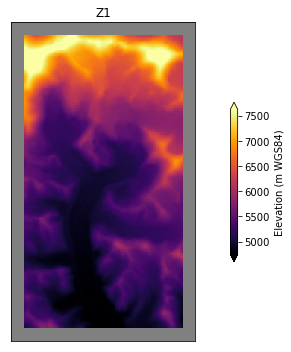

In [7]:
titles = ['Z1']
z1_full2plot = gf.z1
z1_full2plot.mask = dems_mask
clim = malib.calcperc(z1_full2plot, (2,98))
plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

RGI60-15.03473


Text(0.5, 1, 'UTM (m)')

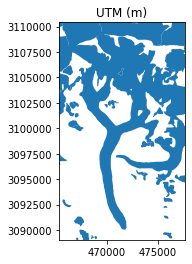

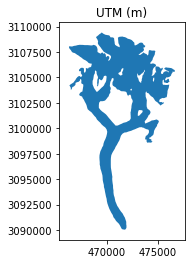

In [8]:
# Plot single glacier
rgiid = 'RGI60-' + gf.feat_fn.split('_')[0].split('.')[0].zfill(2) + '.' + gf.feat_fn.split('_')[0].split('.')[1]
glac_shp_proj = gpd.read_file(glac_shp_proj_fn)
glac_shp_single = glac_shp_proj[glac_shp_proj['RGIId'] == rgiid]
glac_shp_single = glac_shp_single.reset_index()

print(rgiid)

# Plot over region of interest
ax = glac_shp_proj.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")

ax = glac_shp_single.plot()
xlim = (warp_extent[0], warp_extent[2])
ylim = (warp_extent[1], warp_extent[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("UTM (m)")



HACK TO BYPASS VALID AREA




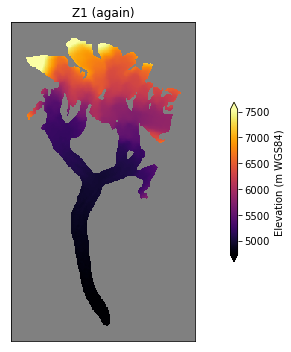

In [9]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# nan_mask = np.ma.masked_invalid(gf.dz)
# glac_geom_mask = np.ma.mask_or(glac_geom_mask, nan_mask.mask)
gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)
# gf.z2 = np.ma.array(gf.z2, mask=glac_geom_mask)
# gf.dz = np.ma.array(gf.dz, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

print('\n\nHACK TO BYPASS VALID AREA\n\n')
gf.valid_area_perc = 100

# print('dz_count:', gf.dz.count())
# print(gf.dz.compressed()))

# #Compute area covered by valid pixels in m2
# gf.valid_area = gf.dz.count() * gf.res[0] * gf.res[1]
# #Compute percentage covered by total area of polygon
# gf.valid_area_perc = 100. * (gf.valid_area / gf.glac_area)
# if verbose:
#     print('valid area %:', gf.valid_area_perc)

# titles = ['Z1']
# z1_full2plot = gf.z1
# z1_full2plot.mask = dems_mask
# clim = malib.calcperc(z1_full2plot, (2,98))
# plot_array(z1_full2plot, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='dem.png')

titles = ['Z1 (again)']
clim = malib.calcperc(gf.z1, (2,98))
plot_array(gf.z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn=outdir_fig + glac_str + '_dem.png')

In [10]:
if gf.valid_area_perc < (100. * min_valid_area_perc):
    if verbose:
        print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
#     return None

else:
    #Filter dz - throw out abs differences >150 m

    #Compute dz, volume change, mass balance and stats
    gf.z1_stats = malib.get_stats(gf.z1)
    z1_elev_med = gf.z1_stats[5]
    z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))
    
    #Caluclate stats for aspect and slope using z2
    #Requires GDAL 2.1+
    gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
    gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
    z1_aspect_med = gf.z1_aspect_stats[5]
    gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
    gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
    z1_slope_med = gf.z1_slope_stats[5]

#     #Load timestamp array, if available
#     if 'z1_date' in ds_dict:
#         gf.t1 = iolib.ds_getma(ds_dict['z1_date'])
#     else:
#         if isinstance(gf.t1, datetime):
#             gf.t1 = float(timelib.dt2decyear(gf.t1))
#         #else, assume we've hardcoded decimal year
#     gf.t1_mean = np.mean(gf.t1)

#     if 'z2_date' in ds_dict:
#         gf.t2 = iolib.ds_getma(ds_dict['z2_date'])
#     else:
#         if isinstance(gf.t2, datetime):
#             gf.t2 = float(timelib.dt2decyear(gf.t2))
#         #else, assume we've hardcoded decimal year
#     gf.t2_mean = np.mean(gf.t2)


    #Can estimate ELA values computed from hypsometry and typical AAR
    #For now, assume ELA is mean
    gf.z1_ela = None
    gf.z1_ela = gf.z1_stats[3]
#     gf.z2_ela = gf.z2_stats[3]
    #Note: in theory, the ELA should get higher with mass loss
    #In practice, using mean and same polygon, ELA gets lower as glacier surface thins
    if verbose:
        print("ELA(t1): %0.1f" % gf.z1_ela)
#         print("ELA(t2): %0.1f" % gf.z2_ela)

    """
    # This attempted to assign different densities above and below ELA
    if gf.z1_ela is None:
        gf.mb = gf.dhdt * rho_is
    else:
        #Initiate with average density
        gf.mb = gf.dhdt*(rho_is + rho_f)/2.
        #Everything that is above ELA at t2 is elevation change over firn, use firn density
        accum_mask = (gf.z2 > gf.z2_ela).filled(0).astype(bool)
    gf.mb[accum_mask] = (gf.dhdt*rho_f)[accum_mask]
    #Everything that is below ELA at t1 is elevation change over ice, use ice density
    abl_mask = (gf.z1 <= gf.z1_ela).filled(0).astype(bool)
    gf.mb[abl_mask] = (gf.dhdt*rho_is)[abl_mask]
    #Everything in between, use average of ice and firn density
    #mb[(z1 > z1_ela) || (z2 <= z2_ela)] = dhdt*(rhois + rho_f)/2.
    #Linear ramp
    #rho_f + z2*((rho_is - rho_f)/(z2_ela - z1_ela))
    #mb = np.where(dhdt < ela, dhdt*rho_i, dhdt*rho_s)
    """

    #Old approach
    #This is mb uncertainty map
    #gf.mb_sigma = np.ma.abs(gf.mb) * np.sqrt((rho_sigma/rho_is)**2 + (gf.dhdt_sigma/gf.dhdt)**2)
    #gf.mb_sigma_stats = malib.get_stats(gf.mb_sigma)
    #This is average mb uncertainty
    #gf.mb_mean_sigma = gf.mb_sigma_stats[3]

    #Now calculate mb for entire polygon
    #gf.mb_mean_totalarea = gf.mb_mean * gf.glac_area
    #Already have area uncertainty as percentage, just use directly
    #gf.mb_mean_totalarea_sigma = np.ma.abs(gf.mb_mean_totalarea) * np.sqrt((gf.mb_mean_sigma/gf.mb_mean)**2 + area_sigma_perc**2)

    #z2_elev_med, z2_elev_min, z2_elev_max, z2_elev_p16, z2_elev_p84, \
    outlist = [gf.glacnum, gf.cx, gf.cy, \
            z1_elev_med, z1_elev_min, z1_elev_max, \
            z1_slope_med, z1_aspect_med, \
#             gf.dhdt_mean, gf.dhdt_sigma, \
#             gf.mb_mean, gf.mb_mean_sigma, \
            gf.glac_area, 
#                gf.mb_total, gf.mb_total_sigma, \
#             gf.t1_mean, gf.t2_mean, gf.dt_mean, 
               gf.valid_area_perc]
    print(outlist)

    if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
        if 'ice_thick' in ds_dict:
            #Load ice thickness
            gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
            gf.H_mean = gf.H.mean()
        #These should be NaN or None
        outlist.append(gf.H_mean)
        print(outlist)

#         if 'debris_thick' in ds_dict:
#             gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['debris_thick']), mask=glac_geom_mask)
#             gf.debris_thick_mean = gf.debris_thick.mean()
#         outlist.append(gf.debris_thick_mean)

#         if 'debris_class' in ds_dict:
#             #Load up debris cover maps
#             #Classes are: 1 = clean ice, 2 = debris, 3 = pond
#             gf.debris_class = np.ma.array(iolib.ds_getma(ds_dict['debris_class']), mask=glac_geom_mask)

#             #Compute debris/pond/clean percentages for entire polygon
#             if gf.debris_class.count() > 0:
#                 gf.perc_clean = 100. * (gf.debris_class == 1).sum()/gf.debris_class.count()
#                 gf.perc_debris = 100. * (gf.debris_class == 2).sum()/gf.debris_class.count()
#                 gf.perc_pond = 100. * (gf.debris_class == 3).sum()/gf.debris_class.count()
#             outlist.extend([gf.perc_debris, gf.perc_pond, gf.perc_clean])

        if 'vx' in ds_dict and 'vy' in ds_dict:
            #Load surface velocity maps
            gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
            gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
            gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
            gf.vm_mean = gf.vm.mean()
            
            print(gf.vm_mean)

            if gf.H is not None:
                #Compute flux
                gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                #Want x-derivative of x component
                gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

#                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
#                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                #Should smooth divQ, better handling of data gaps
                
    
        outlist.append(gf.vm_mean)
        print(outlist)

    if verbose:
        print('Area [km2]:', gf.glac_area / 1e6)
#         print('Mean mb: %0.2f +/- %0.2f mwe/yr' % (gf.mb_mean, gf.mb_mean_sigma))
#         print('Sum/Area mb: %0.2f mwe/yr' % (gf.mb_total/gf.glac_area))
#         print('Mean mb * Area: %0.2f +/- %0.2f m3we/yr' % (gf.mb_total, gf.mb_total_sigma))
# #         print('Sum mb: %0.2f m3we/yr' % gf.mb_total)
        print('-------------------------------')
    
    #Set up output header
    
    out_header = '%s,x,y,z_med,z_min,z_max,area_m2,valid_area_perc,slope_med,aspect_med' % glacnum_fieldname
    if extra_layers:
        out_header += ',H_m'
        out_header += ',vm_ma'

    nf = len(out_header.split(','))
    out_fmt = [glacnum_fmt,] + ['%0.3f'] * (nf - 1)
    
    #Write out mb stats for entire polygon - in case processing is interupted
    #out = np.array(outlist, dtype=float)
    out = np.full(len(out_fmt), np.nan)
    out[0:len(outlist)] = np.array(outlist, dtype=float)
    #Note, need a 2D array here, add 0 axis

    print(out)

    np.savetxt(out_csv_fn, out[np.newaxis,:], fmt=out_fmt, delimiter=',', header=out_header, comments='')
        

ELA(t1): 5812.5
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100]
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100, 113.6750727250379]
13.25236868521326
['15.03473', 471305.76429221936, 3103194.016120774, 5815.416015625, 4705.715529296875, 8160.9415585937495, 12.004107475280762, 179.98648071289062, 61006649.622459464, 100, 113.6750727250379, 13.25236868521326]
Area [km2]: 61.00664962245946
-------------------------------
[1.50347300e+01 4.71305764e+05 3.10319402e+06 5.81541602e+03
 4.70571553e+03 8.16094156e+03 1.20041075e+01 1.79986481e+02
 6.10066496e+07 1.00000000e+02 1.13675073e+02 1.32523687e+01]


In [11]:
#Do AED for all
#Compute mb using scaled AED vs. polygon
#Check for valid pixel count vs. feature area, fill if appropriate

if mb_plot and (gf.glac_area_km2 > min_glac_area_writeout):
    print('plot?')
#     dz_clim = (-2.0, 2.0)
#     if site == 'hma':
#         dz_clim = (-3.0, 3.0)
    z_bin_edges = hist_plot(gf, outdir, bin_width=bin_width)
#     gf.z1_hs = geolib.gdaldem_mem_ds(ds_dict['z1'], processing='hillshade', returnma=True)
#     gf.z2_hs = geolib.gdaldem_mem_ds(ds_dict['z2'], processing='hillshade', returnma=True)
#     map_plot(gf, z_bin_edges, outdir, dz_clim=dz_clim)

plot?
2


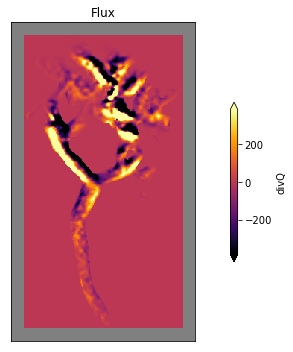

In [12]:
titles = ['Flux']
divQ_full2plot = gf.divQ
divQ_full2plot.mask = dems_mask
clim = malib.calcperc(divQ_full2plot, (2,98))
plot_array(divQ_full2plot, clim, titles, 'inferno', 'divQ', fn=outdir_fig + glac_str +'_divQ.png')

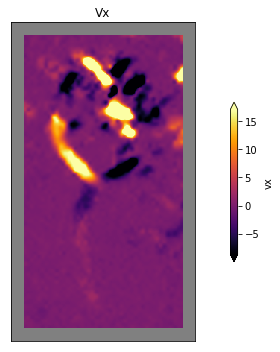

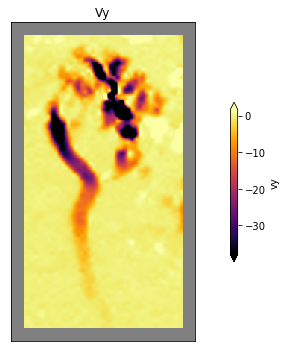

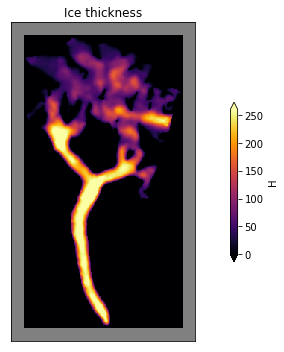

In [13]:
titles = ['Vx']
var_full2plot = gf.vx
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vx', fn=outdir_fig + glac_str +'_vx.png')

titles = ['Vy']
var_full2plot = gf.vy
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'vy', fn=outdir_fig + glac_str +'_vy.png')

titles = ['Ice thickness']
var_full2plot = gf.H
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'H', fn=outdir_fig + glac_str +'_ice_thickness.png')

mean ice thickness: 33.0 m


/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: Warning: converting a masked element to nan.
/Users/davidrounce/anaconda3/envs/debris_thickness_kennicott/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Warning: converting a masked element to nan.


Mass is conserved? False
-527.2238702774048


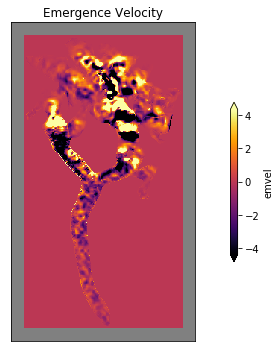

In [14]:
def emergence_pixels(vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
    print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres)
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    print('Mass is conserved?', (volume_final.sum() - volume_initial.sum()) < 0.1 * (xres * yres))
    print(np.nansum(volume_final) - np.nansum(volume_initial))
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity

# Emergence computation
gf.emvel = emergence_pixels(gf.vx, gf.vy, gf.H, gf.res[0], gf.res[1], positive_is_east=False, 
                            positive_is_north=False, constant_icethickness=False, max_velocity=1000, vel_min=0)

titles = ['Emergence Velocity']
var_full2plot = gf.emvel
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'emvel', fn= outdir_fig + glac_str +'_emergence_velocity.png')

In [15]:
#RGI uses 50 m bins
def hist_plot_wemvel(gf, outdir, bin_width=50.0, dz_clim=(-2.0, 2.0)):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(mz1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc,z2_bin_count_valid,z2_bin_area_valid_km2,z2_bin_area_perc,slope_bin_med,aspect_bin_med'
    fmt = '%0.1f,%0.0f,%0.3f,%0.2f,%0.0f,%0.3f,%0.2f,%0.2f,%0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ',dhdt_bin_count,dhdt_bin_area_valid_km2,dhdt_bin_area_perc,dhdt_bin_med_ma,dhdt_bin_mad_ma,dhdt_bin_mean_ma,dhdt_bin_std_ma,mb_bin_med_mwea,mb_bin_mad_mwea,mb_bin_mean_mwea,mb_bin_std_mwea'
        fmt += ', %0.0f,%0.3f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.debris_thick is not None:
        outbins_header += ',debris_thick_med_m,debris_thick_mad_m'
        fmt += ',%0.2f,%0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    if gf.debris_class is not None:
        outbins_header += ',perc_debris,perc_pond,perc_clean,dhdt_debris_med,dhdt_pond_med,dhdt_clean_med'
        fmt += ',%0.2f,%0.2f,%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ',vm_med,vm_mad'
        fmt += ',%0.2f,%0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
#         outbins_header += ', H_mean, H_std'
#         fmt += ', %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std])
        outbins_header += ',H_mean,H_std,emvel_mean,emvel_std'
        fmt += ',%0.2f,%0.2f,%0.2f,%0.2f'
        outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir, gf.feat_fn+'_mb_bins_wemvel.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)

    #Create plots of elevation bins
    #print("Generating aed plot")
    #f,axa = plt.subplots(1,2, figsize=(6, 6))
    nsubplots = 0
    if gf.dhdt is not None:
        nsubplots += 1
    if gf.debris_thick is not None:
        nsubplots += 1
    if gf.vm is not None:
        nsubplots += 1
    if gf.H is not None:
        nsubplots += 1
    print(nsubplots)
    f,axa = plt.subplots(1,nsubplots, squeeze=False, figsize=(10, 7.5))
    f.suptitle(gf.feat_fn)
    fs = 9
    nplot = -1
    if gf.dhdt is not None:
        nplot += 1
        axa[0,nplot].plot(z1_bin_areas, z_bin_centers, label='%0.2f' % gf.t1_mean)
        axa[0,nplot].axhline(gf.z1_ela, ls=':', c='C0')
        if gf.z2 is not None:
            axa[0,nplot].plot(z2_bin_areas, z_bin_centers, label='%0.2f' % gf.t2_mean)
            axa[0,nplot].axhline(gf.z2_ela, ls=':', c='C1')
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_ylabel('Elevation (m WGS84)', fontsize=fs)
        axa[0,nplot].set_xlabel('Area $\mathregular{km^2}$', fontsize=fs)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[0])

        nplot += 1
        axa[0,nplot].axvline(0, lw=1.0, c='k')
        """
        #Plot flux divergence values for each bin
        if gf.vm is not None and gf.H is not None:
            divQ_bin_mean = np.gradient(H_bin_mean * vm_bin_med * v_col_f)
            axa[1].plot(divQ_bin_mean, z_bin_centers, color='green')
        """
        axa[0,nplot].plot(mb_bin_med, z_bin_centers, color='k')
        axa[0,nplot].axvline(gf.mb_mean, lw=0.5, ls=':', c='k', label='%0.2f m w.e./yr' % gf.mb_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, mb_bin_med-mb_bin_mad, mb_bin_med+mb_bin_mad, color='k', alpha=0.1)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med<0), color='r', alpha=0.2)
        axa[0,nplot].fill_betweenx(z_bin_centers, 0, mb_bin_med, where=(mb_bin_med>0), color='b', alpha=0.2)
        #axa[nplot].set_xlabel('dh/dt (m/yr)')
        axa[0,nplot].set_xlabel('Mass balance (m w.e./yr)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[1])
        #Hide y-axis labels
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].set_xlim(*dz_clim)

    if gf.debris_thick is not None:
        nplot += 1
        axa[0,nplot].errorbar(debris_thick_med*100., z_bin_centers, xerr=debris_thick_mad*100, color='k', fmt='o', ms=3, label='Debris Thickness', alpha=0.6)
    if gf.debris_class is not None:
        axa[0,nplot].plot(perc_debris, z_bin_centers, color='sienna', label='Debris Coverage')
        axa[0,nplot].plot(perc_pond, z_bin_centers, color='turquoise', label='Pond Coverage')
    if gf.debris_thick is not None or gf.debris_class is not None:
        axa[0,nplot].set_xlim(0, 100)
        axa[0,nplot].yaxis.set_ticks_position('both')
        # pltlib.minorticks_on(axa[2])
        axa[0,nplot].axes.yaxis.set_ticklabels([])
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        axa[0,nplot].set_xlabel('Debris thickness (cm), coverage (%)', fontsize=fs)

    if gf.H is not None:
        nplot += 1
        axa[0,nplot].plot(H_bin_mean, z_bin_centers, color='b', label='H (%0.2f m)' % gf.H_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, H_bin_mean-H_bin_std, H_bin_mean+H_bin_std, color='b', alpha=0.1)
        axa[0,nplot].set_xlabel('Ice Thickness (m)', fontsize=fs)
        axa[0,nplot].legend(prop={'size':8}, loc='lower right')
        # pltlib.minorticks_on(axa[3])
        #axa[nplot].set_xlim(0, 400)
        axa[0,nplot].yaxis.tick_left()
        axa[0,nplot].yaxis.set_ticks_position('both')
        axa[0,nplot].yaxis.set_label_position("right")
    
    if gf.vm is not None:
        nplot += 1
#         ax4 = axa[0,nplot].twinx()
        axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
        axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
        axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
        #ax4.set_xlim(0, 50)
        axa[0,nplot].xaxis.tick_bottom()
        axa[0,nplot].xaxis.set_label_position("bottom")
        axa[0,nplot].legend(prop={'size':8}, loc='upper right')
        
        nplot += 1
#         axa[0,nplot].set_xlabel('divQ (??)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')
#         gf.divQ
    
#     if gf.vm is not None:
#         nplot += 1
# #         ax4 = axa[0,nplot].twinx()
#         axa[0,nplot].set_xlabel('Velocity (m/yr)', fontsize=fs)
#         axa[0,nplot].plot(vm_bin_med, z_bin_centers, color='g', label='Vm (%0.2f m/yr)' % gf.vm_mean)
#         axa[0,nplot].fill_betweenx(z_bin_centers, vm_bin_med-vm_bin_mad, vm_bin_med+vm_bin_mad, color='g', alpha=0.1)
#         #ax4.set_xlim(0, 50)
#         axa[0,nplot].xaxis.tick_bottom()
#         axa[0,nplot].xaxis.set_label_position("bottom")
#         axa[0,nplot].legend(prop={'size':8}, loc='upper right')

    plt.tight_layout()
    #Make room for suptitle
    plt.subplots_adjust(top=0.95, wspace=0.1)
    #print("Saving aed plot")
    fig_fn = os.path.join(outdir_fig, gf.feat_fn+'_mb_aed.png')
    #plt.savefig(fig_fn, bbox_inches='tight', dpi=300)
    plt.savefig(fig_fn, dpi=300)
    plt.close(f)
    return z_bin_edges

z_bin_edges = hist_plot_wemvel(gf, outdir_csv, bin_width=bin_width)

2


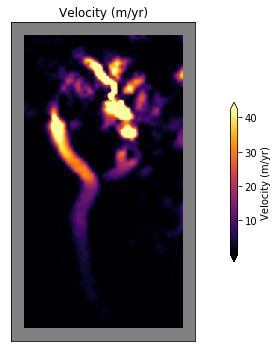

In [16]:
gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

titles = ['Velocity (m/yr)']
var_full2plot = gf.vtot
var_full2plot.mask = dems_mask
clim = malib.calcperc(var_full2plot, (2,98))
plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png')

In [3]:
# # ===== TESTING Z2 CREATION WORKS =====
# #Warp everything to common res/extent/proj
# ds_list = warplib.memwarp_multi_fn([z1_fn, dhdt_fn, z2_fn], 
#                                    res='min', t_srs=aea_srs, verbose=verbose, r='cubic')
# # DEM masks
# ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
# z1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
# dhdt = ds_list_masked[1]
# z2 = ds_list_masked[2]

# titles = ['z1']
# clim = malib.calcperc(z1, (2,98))
# plot_array(z1, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z1.png')

# titles = ['dhdt']
# clim = malib.calcperc(dhdt, (2,98))
# plot_array(dhdt, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z1.png')

# titles = ['z2']
# clim = malib.calcperc(z2, (2,98))
# plot_array(z2, clim, titles, 'inferno', 'Elevation (m WGS84)', fn='z2.png')

In [18]:
z1_fn

'/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/surface_DEMs_RGI60-15/surface_DEM_RGI60-15.03473.tif'

In [21]:
#====== BIN DEBRIS THICKNESS FROM THERMAL METHOD ======
debris_fullfn = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/Landsat_8/ngoz_ts/ngoz_debristhickness_20150930.tif'
ts_fullfn = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/Landsat_8/ngoz_ts/ngoz_tsurfC_20150930.tif'

# #INPUT
# topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# #Output directory
# outdir = topdir + 'kennicott/'
# outdir_fig = outdir + '/figures/'
# outdir_csv = outdir + '/csv'

# #RGI inventory
# # glac_shp_fn = '/Users/davidrounce/Documents/Dave_Rounce/Satellite_Images/Kennicott_glacier.shp'
# # glacfeat_fn = outdir + 'glacfeat_list.p'
# #DEM
# # z1_fn = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/Alaska_albers_V3_mac/Alaska_albers_V3.tif'
# # Ice thickness
# # huss_dir = '/Users/davidrounce/Documents/Dave_Rounce/DebrisGlaciers_WG/Melt_Intercomparison/rounce_model/kennicott_data/'
# # huss_fn = 'thick_kennicott_HH2012.tif'

#Output projection
proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
ds = gdal.Open(proj_fn)
prj = ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)
aea_srs = srs

# Process RGI shapefile
if 'rgi' in glac_shp_fn or 'Kennicott' in glac_shp_fn:
    #Use RGI
    glacname_fieldname = "Name"
    #RGIId (String) = RGI50-01.00004
    glacnum_fieldname = "RGIId"
    glacnum_fmt = '%08.5f'
else:
    sys.exit('Unrecognized glacier shp filename')

# Shape layer processing
glac_shp_init = gpd.read_file(glac_shp_fn)
if verbose:
    print('Shp init crs:', glac_shp_init.crs)

# If projected shapefile already exists, then skip projection
glac_shp_proj_fn = (outdir + glac_shp_fn.split('/')[-1].replace('.shp','_crs' +
                                                                str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'))
if os.path.exists(glac_shp_proj_fn) == False:
    glac_shp_proj = glac_shp_init.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
    glac_shp_proj.to_file(glac_shp_proj_fn)
    
glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
glac_shp_lyr = glac_shp_ds.GetLayer()
#This should be contained in features
glac_shp_srs = glac_shp_lyr.GetSpatialRef()
feat_count = glac_shp_lyr.GetFeatureCount()
print("Input glacier polygon count: %i" % feat_count)

z1_ds = gdal.Open(z1_fn)
z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

fn_dict = OrderedDict()
#We at least want to warp the two input DEMs
fn_dict['z1'] = z1_fn
# fn_dict['debris_thick'] = debris_fullfn
fn_dict['ts'] = ts_fullfn

#Expand extent to include buffered region around glacier polygon
warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
if verbose:
    print("Expanding extent")
    print(gf.glac_geom_extent)
    print(warp_extent)
    print(aea_srs)


    #Warp everything to common res/extent/proj
    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
            r='cubic')

    ds_dict = dict(zip(fn_dict.keys(), ds_list))
    
    print(ds_list)
    print(fn_dict.keys())
    
    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    glac_shp_lyr = glac_shp_ds.GetLayer()
    #Spatial filter
#     glac_shp_lyr.SetSpatialFilter(geom)

    #Get global glacier mask
    #Want this to be True over ALL glacier surfaces, not just the current polygon
    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['z1'])
    
    #geom srs is not preserved when loaded from disk, attempt to reassign
#     gf.geom_srs_update()
    #Create buffer around glacier polygon
    glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
    #This is False over glacier polygon surface, True elsewhere - can be applied directly
    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['z1'])
    
    # ds masks
    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
    dems_mask = dem1.mask
    if verbose:
        print('list of datasets:', len(ds_list_masked), fn_dict.values())
    
    #Combine to identify ~1 km buffer around glacier polygon over static rock
    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

    if 'z1' in ds_dict:
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
#         gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['debris_thick']), mask=glac_geom_mask)
        gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
        print('\n\n# z1 pixels:', gf.z1.count(), '\n')
        if gf.z1.count() == 0:
            if verbose:
                print("No z1 pixels")
#             return None
    else:
        print("Unable to load z1 ds")
#         return None

Shp init crs: {'init': 'epsg:4326'}
Input glacier polygon count: 13119
Expanding extent
[466274.413315571, 3090038.90589917, 476685.521575542, 3109419.82835597]
[465274.413315571, 3089038.90589917, 477685.521575542, 3110419.82835597]
PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32645"]]

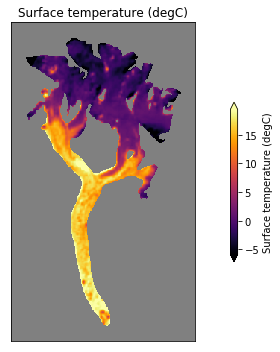

In [22]:
#Now apply glacier mask AND mask NaN values
glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
gf.ts = np.ma.array(gf.ts, mask=glac_geom_mask)
# gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# gf.debris_thick[gf.debris_thick>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Surface temperature (degC)']
clim = malib.calcperc(gf.ts, (2,98))
plot_array(gf.ts, clim, titles, 'inferno', 'Surface temperature (degC)', fn='../ts.png')

In [23]:
gf.ts.max()

27.651813733307375

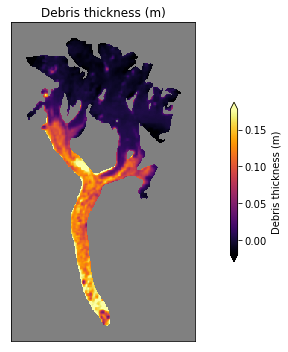

In [24]:
#Now apply glacier mask AND mask NaN values
# glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# gf.debris_thick = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
k = 0.13
Tsmax_offset = 6
Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick = gf.ts * 0.13 / (Tsmax - gf.ts)

# gf.debris_thick = np.ma.array(gf.debris_thick, mask=glac_geom_mask)
# gf.debris_thick  = np.ma.masked_less_equal(gf.debris, 0)
# gf.debris_thick[gf.debris_thick>1] = 1

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Debris thickness (m)']
clim = malib.calcperc(gf.debris_thick, (2,98))
plot_array(gf.debris_thick, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

In [25]:
gf.ts.max()

27.651813733307375

In [27]:
#RGI uses 50 m bins
def hist_plot_wdebris(gf, outdir, bin_width=50.0):

    z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #Create arrays to store output
    if gf.debris_thick is not None:
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
    else:
        print('NO DEBRIS THICKNESS!')

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)

    outbins_header = 'bin_center_elev_m,z1_bin_count_valid,z1_bin_area_valid_km2,z1_bin_area_perc'
    fmt = '%0.1f,%0.0f,%0.3f,%0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc]
    if gf.debris_thick is not None:
        outbins_header += ',debris_thick_med_m,debris_thick_mad_m'
        fmt += ',%0.2f,%0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])

    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    outbins_fn = os.path.join(outdir, gf.feat_fn+'_mb_bins_wdebris.csv')
    np.savetxt(outbins_fn, outbins, fmt=fmt, delimiter=',', header=outbins_header)
    return z_bin_edges

z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=5)